In [ ]:
%pip install segmentation-models &> /dev/null
%load_ext tensorboard
!cp '/content/drive/MyDrive/Transfere Learning research/Notebooks/unet_util.py' .

import shutil
import numpy as np
import tensorflow as tf
from keras import backend as K
import segmentation_models as sm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from unet_util import dice_coef_loss, dice_coef, jacard_coef, dice_coef_loss, Residual_CNN_block, multiplication, attention_up_and_concatenate, multiplication2, attention_up_and_concatenate2, UNET_224, evaluate_prediction_result

sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
% cd '/content/drive/MyDrive/Transfere Learning research/Notebooks/'
import os

# Define data, models, and prediction paths
input_data = './samples/'
model_path = './models/'
prediction_path = './predicts/'

# Avaiable backbones for Unet architechture
# 'vgg16' 'vgg19' 'resnet18' 'resnet34' 'resnet50' 'resnet101' 'resnet152' 'inceptionv3' 
# 'inceptionresnetv2' 'densenet121' 'densenet169' 'densenet201' 'seresnet18' 'seresnet34' 
# 'seresnet50' 'seresnet101' 'seresnet152', and 'attentionUnet'
backend = 'vgg19'

# Sample Location or Source Location
# 'covington' 'rowancreek' 'alaska'
source_location = 'covington'

# select Transfered model
is_transfer = False

# Target Location
# 'covington' 'rowancreek' 'alaska'
target_location = 'rowancreek'

if(is_transfer):
  # The model name in the case of transfer from source to target location
  model_name = source_location+'-to-'+target_location+'-Unet-'+backend
  location = target_location
else: 
  # The model name in the case of no transfer
  model_name = source_location+'-Unet-'+backend +'-tf'
  location = source_location

print('model location: '+ model_path+model_name +'.h5')
print('H5 file exists: ' + str(os.path.exists(model_path + model_name + '.h5')))

if(not os.path.exists(prediction_path + model_name + '_predict.npy')): 
  print("prediction not exists")

else:
  print("exists")

/content/drive/MyDrive/Transfere Learning research/Notebooks
model location: ./models/covington-Unet-attentionUnet-tf.h5
H5 file exists: True
exists


In [ ]:
# if(not os.path.exists(prediction_path + model_name + '_predict.npy')): 
#   # Load the best model saved by the callback module
#   from keras.models import load_model
#   if(backend != "attentionUnet"):
#     best_model = load_model(model_path + model_name + '.h5',
#                           custom_objects={'dice_coef_loss':dice_coef_loss,
#                                           'dice_coef':dice_coef,})
#   else:
#     best_model = load_model(model_path + model_name + '.h5',
#                           custom_objects={'multiplication': multiplication,
#                                           'multiplication2': multiplication2,
#                                           'dice_coef_loss':dice_coef_loss, 
#                                           'dice_coef':dice_coef,})

#   # load the test data
#   X_test = np.load(input_data+location+'/bottom_half_test_data.npy').astype(np.float32)

#   # predict the test data using the loaded model
#   test_predicted= best_model.predict(X_test)

#   # convert the prediction probability to true or false with threshold at 0.5
#   test_predicted_threshold = (test_predicted > 0.5).astype(np.uint8)

#   # save the prediction results
#   np.save(prediction_path + model_name + '_predict.npy',test_predicted_threshold)
#   print('Predtion results saved: ' + prediction_path + model_name + '_predict.npy')

Predtion results saved: ./predicts/rowancreek-Unet-densenet169-tf_predict.npy


In [ ]:
pred_npy = prediction_path + model_name + '_predict.npy'
mask_npy = input_data + location + '/bottom_half_test_mask.npy'
label_npy = input_data + location + '/bottom_half_test_label.npy'
model = model_path + model_name + '.h5'
text_path = prediction_path+'prediction_results.txt'

# evaluate_prediction_result(location, pred_npy, mask_npy, label_npy, model, text_path)

In [ ]:
from PIL import Image as im
import copy
import random
import sys
import numpy as np
from sklearn.metrics import f1_score, precision_score,recall_score
import glob
test_path = '/content/drive/MyDrive/Transfere Learning research/'

if(not os.path.exists(prediction_path + model_name + '_predict.tif')): 
  print("prediction not exists")

prediction_mask_npy = np.load(mask_npy)
predition_label_npy = np.load(label_npy)
prediction_map = np.array(im.open(prediction_path + model_name + '_predict.tif'))

# mask
mask = prediction_mask_npy[:prediction_map.shape[0],:prediction_map.shape[1]]
[lr,lc] = np.where(mask == 1)
# print("mask",mask.shape)

# Read reference data
groundtruth = predition_label_npy[:prediction_map.shape[0],:prediction_map.shape[1]]
groundtruthlist = predition_label_npy[:prediction_map.shape[0],:prediction_map.shape[1]][lr,lc]
prediction = np.logical_and(prediction_map,mask)
predictionlist = np.logical_and(prediction_map,mask)[lr,lc]

print("Model: " + model_name)
print(str(f1_score(groundtruthlist, predictionlist,labels=[0], average = 'micro')))
print(str(f1_score(groundtruthlist, predictionlist,labels=[1], average = 'micro')))
print(str(precision_score(groundtruthlist, predictionlist,labels=[0], average = 'micro')))
print(str(precision_score(groundtruthlist, predictionlist,labels=[1], average = 'micro')))
print(str(recall_score(groundtruthlist, predictionlist,labels=[0], average = 'micro')))
print(str(recall_score(groundtruthlist, predictionlist,labels=[1], average = 'micro')))


Model: covington-Unet-attentionUnet-tf
0.9944815571020362
0.6967556587222095
0.9944784641836356
0.6968747565841289
0.9944846500396755
0.6966366015616551


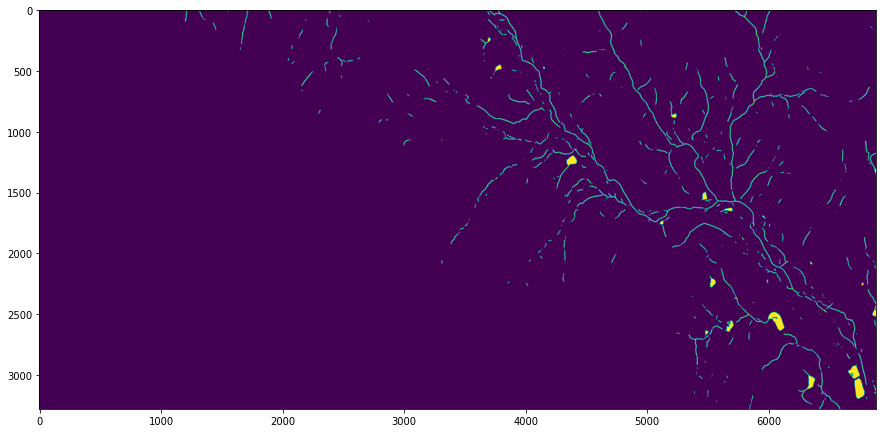

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(15,30))
plt.imshow(prediction_map)